In [1]:
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np

from astropy import units as u
from astropy.coordinates import SkyCoord, Distance
from astropy.table import QTable

from astroquery.gaia import Gaia

Gaia.ROW_LIMIT = 10000  # Set the row limit for returned data

Workaround solutions for the Gaia Archive issues following the infrastructure upgrade: https://www.cosmos.esa.int/web/gaia/news#WorkaroundArchive


In [2]:
ngc188_center = SkyCoord(12.11 * u.deg, 85.26 * u.deg)
ngc188_center

<SkyCoord (ICRS): (ra, dec) in deg
    (12.11, 85.26)>

In [3]:
ngc188_center = SkyCoord(12.11 * u.deg, 85.26 * u.deg, frame="icrs")
ngc188_center

<SkyCoord (ICRS): (ra, dec) in deg
    (12.11, 85.26)>

In [4]:
SkyCoord("00h48m26.4s", "85d15m36s", frame="icrs")

<SkyCoord (ICRS): (ra, dec) in deg
    (12.11, 85.26)>

In [5]:
SkyCoord("00:48:26.4 85:15:36", unit=(u.hour, u.deg), frame="icrs")

<SkyCoord (ICRS): (ra, dec) in deg
    (12.11, 85.26)>

In [6]:
ngc188_center = SkyCoord.from_name("NGC 188")
ngc188_center

<SkyCoord (ICRS): (ra, dec) in deg
    (11.81167, 85.245)>

In [7]:
ngc188_center.ra, ngc188_center.dec

(<Longitude 11.81167 deg>, <Latitude 85.245 deg>)

In [10]:
print(ngc188_center.ra, ngc188_center.dec)
print(type(ngc188_center.ra), type(ngc188_center.dec))

11d48m42.012s 85d14m42s
<class 'astropy.coordinates.angles.core.Longitude'> <class 'astropy.coordinates.angles.core.Latitude'>


In [12]:
(
    ngc188_center.ra.to(u.hourangle),
    ngc188_center.ra.to(u.radian),
    ngc188_center.ra.to(u.degree),
)

(np.float64(0.7874446666666668),
 np.float64(0.2061525316590386),
 np.float64(11.81167))

In [13]:
(ngc188_center.ra.hour, ngc188_center.ra.radian, ngc188_center.ra.degree)

(np.float64(0.7874446666666668),
 np.float64(0.2061525316590386),
 np.float64(11.81167))

In [14]:
ngc188_center.ra.to_string(unit=u.hourangle, sep=":", pad=True)

np.str_('00:47:14.8008')

In [15]:
job = Gaia.cone_search_async(ngc188_center, radius=0.5 * u.deg)
ngc188_table = job.get_results()

# only keep stars brighter than G=19 magnitude
ngc188_table = ngc188_table[ngc188_table["phot_g_mean_mag"] < 19 * u.mag]

INFO: Query finished. [astroquery.utils.tap.core]


In [16]:
cols = [
    "source_id",
    "ra",
    "dec",
    "parallax",
    "parallax_error",
    "pmra",
    "pmdec",
    "radial_velocity",
    "phot_g_mean_mag",
    "phot_bp_mean_mag",
    "phot_rp_mean_mag",
]
ngc188_table[cols].write("gaia_results.fits", overwrite=True)
ngc188_table = QTable.read("gaia_results.fits")
print(len(ngc188_table))

4870


In [17]:
print(ngc188_table["ra"], ngc188_table["dec"])

[11.83025781 11.78143038 11.77583082 ... 13.38035513  6.14281433
 15.88372451] deg [85.24362655 85.24714775 85.24193164 ... 85.71468997 85.14268532
 85.60656188] deg


In [18]:
ngc188_gaia_coords = SkyCoord(ngc188_table["ra"], ngc188_table["dec"])
ngc188_gaia_coords

<SkyCoord (ICRS): (ra, dec) in deg
    [(11.83025781, 85.24362655), (11.78143038, 85.24714775),
     (11.77583082, 85.24193164), ..., (13.38035513, 85.71468997),
     ( 6.14281433, 85.14268532), (15.88372451, 85.60656188)]>

In [19]:
ngc188_center = SkyCoord.from_name("NGC 188")

In [20]:
ngc188_center.to_string(style="hmsdms", sep=":", precision=1)

'00:47:14.8 +85:14:42.0'

In [21]:
ngc188_gaia_coords.separation(ngc188_center)

<Angle [0.00206428, 0.00330055, 0.00427162, ..., 0.48564428, 0.48564554,
        0.48577756] deg>

In [22]:
ngc188_center_3d = SkyCoord(12.11 * u.deg, 85.26 * u.deg, distance=1.96 * u.kpc)

In [23]:
parallax_snr = ngc188_table["parallax"] / ngc188_table["parallax_error"]
ngc188_table_3d = ngc188_table[parallax_snr > 10]
len(ngc188_table_3d)

2423

In [24]:
Distance(parallax=1 * u.mas)

<Distance 1000. pc>

In [25]:
gaia_dist = Distance(parallax=ngc188_table_3d["parallax"].filled(np.nan))

In [26]:
ngc188_coords_3d = SkyCoord(
    ra=ngc188_table_3d["ra"], dec=ngc188_table_3d["dec"], distance=gaia_dist
)
ngc188_coords_3d

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    [(11.83025781, 85.24362655, 2113.23414411),
     (11.77583082, 85.24193164, 1819.25788676),
     (11.79608811, 85.24947769, 1878.68206887), ...,
     (13.38035513, 85.71468997,  820.05330166),
     ( 6.14281433, 85.14268532, 1950.38491004),
     (15.88372451, 85.60656188,  356.47807826)]>

Text(0.5, 1.0, 'Gaia DR2 sources near NGC 188')

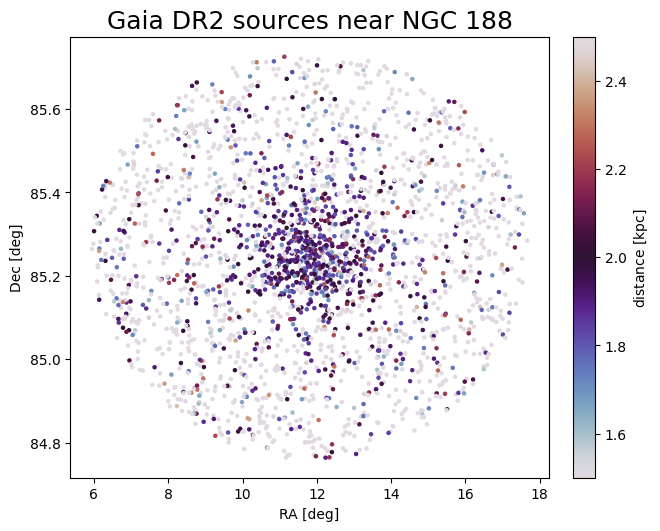

In [27]:
fig, ax = plt.subplots(figsize=(6.5, 5.2), constrained_layout=True)
cs = ax.scatter(
    ngc188_coords_3d.ra.degree,
    ngc188_coords_3d.dec.degree,
    c=ngc188_coords_3d.distance.kpc,
    s=5,
    vmin=1.5,
    vmax=2.5,
    cmap="twilight",
)
cb = fig.colorbar(cs)
cb.set_label(f"distance [{u.kpc:latex_inline}]")

ax.set_xlabel("RA [deg]")
ax.set_ylabel("Dec [deg]")

ax.set_title("Gaia DR2 sources near NGC 188", fontsize=18)

In [28]:
sep3d = ngc188_coords_3d.separation_3d(ngc188_center_3d)
sep3d

<Distance [ 153.23745529,  140.74632654,   81.32334553, ..., 1139.9932356 ,
             19.95841281, 1603.53587294] pc>

In [30]:
ngc188_3d_mask = sep3d < 50 * u.pc
print(ngc188_3d_mask.sum())

262
